# Rozwiązywanie układów równań liniowych
## Laboratorium 2 - Metody Obliczeniowe w Nauce i Technice

In [1]:
import numpy as np
import networkx as nx
from datetime import datetime

## Zadanie 1. Eliminacja Gaussa-Jordana.

In [ ]:
# Gauss-Jordan elimination algorithm with partial pivoting
def gauss_jordan(A):
    n = len(A)
    m = len(A[0])
    h = k = 0

    while h < n and k < m:
        id_max = max([(abs(A[i][k]), i) for i in range(h, n)])[1]
        if A[id_max][k] == 0: k += 1
        else:
            A[[h, id_max]] = A[[id_max, h]]
            for i in range(h + 1, n):
                f = A[i][k] / A[h][k]
                A[i][k] = 0
                for j in range(k + 1, m): A[i][j] -= f * A[h][j]
            h += 1
            k += 1
            
    return A

# Backward substitution
def backward_substitution(A):
    n = len(A)
    m = len(A[0])
    
    for h in range(n - 1, -1, -1):
        A[h][m - 1] *= 1 / A[h][h]
        A[h][h] = 1
        for i in range(h - 1, -1, -1):
            f = A[i][h]
            A[i][h] = 0
            for j in range(h + 1, m): A[i][j] -= f * A[h][j]
            
    return A


# Linear solver
def lin_solve(A, y):
    n = len(A)
    Ay = np.hstack((A, np.array([[x] for x in y])))
    Ay = backward_substitution(gauss_jordan(Ay))
    
    return np.array([x[n] for x in Ay])

In [ ]:
dimensions = np.array([
    (510, 510),
    (520, 520),
    (530, 530),
    (540, 540),
    (550, 550),
    (600, 600),
    (650, 650),
    (700, 700),
    (750, 750),
    (800, 800),
    (1000, 1000),
])

# Tests
for n, m in dimensions:
    start_timestamp = datetime.timestamp(datetime.now())
    lin_solve(np.random.rand(n, m), np.random.rand(n))
    end_timestamp = datetime.timestamp(datetime.now())

## Zadanie 2. Faktoryzacja LU.

In [5]:
# With partial pivoting Sadeg =(
def lu_decomposition(A):
    n = len(A)
    L = np.zeros((n, n))
    h = k = 0

    while h < n and k < n:
        id_max = -1
        for i in range(h, n):
            if A[i][k] != 0:
                id_max = i
                break
                
        if id_max < 0: k += 1
        else:
            A[[h, id_max]] = A[[id_max, h]]
            L[h][h] = 1
            for i in range(h + 1, n):
                f = A[i][k] / A[h][k]
                A[i][k] = 0
                L[i][h] = f
                for j in range(k + 1, n): A[i][j] -= f * A[h][j]
            h += 1
            k += 1
            
    return L, A

In [4]:
A = np.array([[1,2,3],[5,8,-4],[3,-2,7]])
L, U = lu_decomposition(np.copy(A))
L, U

(array([[1., 0., 0.],
        [5., 1., 0.],
        [3., 4., 1.]]),
 array([[  1,   2,   3],
        [  0,  -2, -19],
        [  0,   0,  74]]))

Poprawność algorytmu dekompozycji $LU$, obliczając $||A - LU||_1$

In [14]:
# Matrix norm of A - LU inducted by vector 1-norms
np.max((np.abs(A - np.dot(L, U))).sum(axis=1))

0.0

## Zadanie 3. Analiza obwodu elektrycznego - nadokreślony układ równań.

In [ ]:
def load_adjacency_list_from_file(path):
    with open(path) as file:
        adj_list = []
        lines = [line.rstrip() for line in file]
        
        for i in range(len(lines)):
            row = line.split(',')
            for j in range(0, len(row), 2):
                adj_list[i].append((int(row[j]), float(row[j + 1])))
                
        return adj_list
    
    return None


def adjacency_matrix_from_list(G):
    M = np.zeros((len(G), len(G)))
    for i in range(len(G)):
        for j, w in G[i]:
            M[i][j] = w
            
    return M
    

def load_emf():
    s, t, E = input("Type electromotive force E from s to v vertices (s t E): ").split()
    return int(s), int(t), float(E)

In [ ]:
# Ohm's law
def ol()

![Test graph](graph-test.jpg)

In [14]:
# Test graph
G = nx.Graph()
G.add_weighted_edges_from([
    (1, 0, -1),
    (1, 4, 1),
    (1, 2, 1),
    (2, 3, 1),
    (3, 4, 1),
    (4, 5, 1),
    (5, 6, 1),
    (6, 0, 1),
    (3, 7, 1),
    (4, 7, 1),
    (7, 8, 1),
    (8, 5, 1)
])
s, t = 0, 1
# nx.draw(nx.DiGraph(G))

In [19]:
G_cycle_basis = nx.cycle_basis(G)
G_cycle_basis

[[4, 7, 8, 5], [4, 3, 7], [1, 2, 3, 7, 8, 5, 6, 0], [1, 4, 5, 6, 0]]

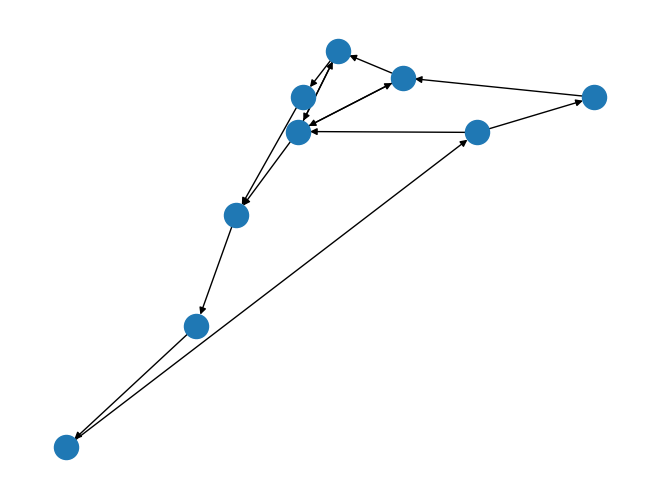

In [26]:
def parse_to_directed(G, s, t, cycles):
    di_G = G.to_directed()
    
    for cycle in cycles:
        if s in cycle or t in cycle:
            idx = cycle.index(t)
            n = len(cycle)
            for i in range(n):
                v, u = cycle[(idx + i) % n], cycle[(idx + i - 1) % n]
                if di_G.has_edge(v, u): di_G.remove_edge(v, u)
                
    for cycle in cycles:
        if s not in cycle or t not in cycle:
            n = len(cycle)
            idx = None
            for i in range(n):
                v, u = cycle[i % n], cycle[(i - 1) % n]
                if di_G.has_edge(v, u) and not di_G.has_edge(u, v):
                    idx = i
                    break
                    
            if idx is None: continue
            for i in range(n):
                v, u = cycle[(idx + i) % n], cycle[(idx + i - 1) % n]
                if di_G.has_edge(v, u): di_G.remove_edge(v, u)
            
    return di_G


nx.draw(parse_to_directed(G, s, t, G_cycle_basis))

### Metoda potencjałów węzłowych.

In [ ]:
def branch_current_method(G, s, t, e):
    N = len(G)
    
    A = np.zeros((N, N))
    B = np.zeros(N)
    
    V = np.full(N, None)
    V[s] = 0
    V[t] = e
    
    for u in range(N):
        # out
        for v in range(N):
            if G[u][v] == 0:
                continue
                
            A[u] -= 1 / G[u][v]
            if V[v] is None: A[u] += 1 / G[u][v]
            else: B[u] -= V[v] / G[u][v]
        
        # in
        for v in range(N):
            if G[v][u] == 0:
                continue
                
            A[u] += 1 / G[u][v]
            if V[v] is None: A[u] -= 1 / G[u][v]
            else: B[u] += V[v] / G[u][v]
            
            
    V = np.linalg.solve(A, B)
    return V


branch_current_method(np.array())